In [1020]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import psycopg2
from src.scraper import *
from src.process_words import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import datetime as dt
import pickle

In [1021]:
conn = psycopg2.connect(dbname='food_db')
df = pd.read_sql('SELECT * FROM recipes', con=conn)
df['food_stems'] = [clean_one_doc(recipe) for recipe in df['foods']]

In [1022]:
df.head()

,id,post_date,title,foods,food_stems
0,27,2018-02-09,Long Life Noodles with Shrimp and Greens,"teaspoon sesame oil, for drizzling stalk green...","[sesam, oil, stalk, onion, carrot, stalk, onio..."
1,28,2018-02-09,Ginger-Onion Whole Steamed Fish,"stalks green onions, cut into 3-inch segments,...","[stalk, onion, segment, wine, marsala, wine, o..."
2,29,2018-02-09,Smacked Cucumber,"teaspoon sugar cloves garlic, crushed tablespo...","[sugar, clove, flake, chili, cucumb, cucumb, v..."
3,30,2018-02-08,Neck Bones and Lima Beans,"salt and pepper, to taste tablespoons canola o...","[oil, sage, lima, bean, water, nutmeg, onion, ..."
4,31,2018-02-07,Angel Wings (Faworki),pinch sea salt confectioner’s sugar for servin...,"[sea, confection, cream, egg, yolk, powder, co..."


In [169]:
top_words, label_list = process_words.make_top_words(df, 'foods', 20)

In [170]:
top_words

,2009_1,s2009_1,2009_2,s2009_2,2009_3,s2009_3,2009_4,s2009_4,2010_1,s2010_1,...,2018_17,s2018_17,2018_18,s2018_18,2018_19,s2018_19,2018_20,s2018_20,2018_21,s2018_21
0,oil,0.112582,butter,0.079584,egg,0.188409,chicken,0.155446,nut,0.175772,...,pomegran,0.542747,half,0.301218,cucumb,0.401554,fish,0.533440,haricot,0.292787
1,tomato,0.094246,juic,0.073942,powder,0.162482,mustard,0.100574,pine,0.164861,...,orang,0.428420,sprig,0.282861,flake,0.299136,wine,0.398714,vert,0.292787
2,clove,0.083140,sugar,0.068926,sugar,0.151962,appl,0.075061,beet,0.103152,...,grapefruit,0.361832,pea,0.191812,chili,0.168784,marsala,0.266720,fennel,0.292787
3,onion,0.082706,potato,0.056002,butter,0.121545,oil,0.072764,oil,0.078085,...,flower,0.180916,kosher,0.149123,vinegar,0.122092,snapper,0.266720,bulb,0.292787
4,vinegar,0.048546,water,0.048793,vanilla,0.115941,part,0.069186,green,0.074109,...,creme,0.180916,onion,0.112493,sugar,0.118075,fishmong,0.266720,radish,0.292787
5,lemon,0.039792,oil,0.043581,extract,0.095655,stock,0.067771,mint,0.057374,...,tangerin,0.180916,clove,0.110409,bunch,0.109678,bass,0.266720,frond,0.292787
6,wine,0.035686,cream,0.043502,milk,0.094685,shallot,0.055948,clove,0.054295,...,aril,0.180916,split,0.110211,mirin,0.109678,rock,0.266720,purpl,0.292787
7,cumin,0.035574,cinnamon,0.042788,soda,0.064793,kosher,0.052739,onion,0.053968,...,blossom,0.180916,stuff,0.110211,takara,0.109678,segment,0.241858,dijon,0.231112
8,virgin,0.035046,stick,0.042463,chocol,0.064773,cream,0.051724,parsley,0.049484,...,envelop,0.180916,paprika,0.110211,noodl,0.109678,stalk,0.224219,mustard,0.231112
9,coriand,0.034017,mint,0.040805,appl,0.063527,dijon,0.049162,hand,0.046820,...,fraich,0.180916,pastri,0.105310,shichimi,0.109678,ginger,0.189905,orang,0.231112


In [196]:
y, full_X = process_words.vectorize_all(df, 'foods', split_years=False)

In [198]:
full_X, full_features = full_X

In [199]:
full_X

<4858x3006 sparse matrix of type '<class 'numpy.float64'>'
	with 61899 stored elements in Compressed Sparse Row format>

In [200]:
k = process_words.get_best_k(full_X)
k

4

In [201]:
full_centroids, full_labels = process_words.make_clusters(
    full_X, full_features, k)

In [202]:
full_centroids

array([[ 0.00021565,  0.00062376,  0.00021885, ...,  0.00033375,
         0.00284181,  0.00043928],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00148367,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00704048,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.00119876,  0.        ]])

In [204]:
full_cluster_df, full_labels = process_words.make_one_cluster_df(full_X, full_features, k, 'all')

In [257]:
full_cluster_df.head(20)

,all_1,sall_1,all_2,sall_2,all_3,sall_3,all_4,sall_4
0,sugar,0.171995,oil,0.101683,water,0.059958,chocol,0.321039
1,egg,0.158660,onion,0.069260,juic,0.051703,powder,0.108550
2,butter,0.142325,clove,0.064893,sugar,0.045432,sugar,0.107101
3,vanilla,0.119374,tomato,0.042201,butter,0.036060,vanilla,0.106956
4,milk,0.104353,vinegar,0.041139,orang,0.032373,extract,0.097436
5,extract,0.084208,juic,0.036800,lemon,0.031166,chip,0.097009
6,powder,0.082784,wine,0.034571,honey,0.030089,egg,0.090856
7,cream,0.080846,parsley,0.033721,oil,0.028653,cocoa,0.088334
8,flour,0.059152,sauc,0.032379,milk,0.027895,butter,0.087276
9,yolk,0.051041,kosher,0.029940,egg,0.026508,cream,0.085235


In [208]:
full_X

<4858x3006 sparse matrix of type '<class 'numpy.float64'>'
	with 61899 stored elements in Compressed Sparse Row format>

In [559]:
total = np.sum(full_X, axis=0)
total = np.asarray(total)[0]
top200 = np.array([np.array(full_features)[i] for i in np.argsort(total)[-1:-200-1:-1]])
top50 = np.array([np.array(full_features)[i] for i in np.argsort(total)[-1:-50-1:-1]])
top10 = np.array([np.array(full_features)[i] for i in np.argsort(total)[-1:-10-1:-1]])
print ("top 200 by total tf-idf")
print (top200)

top 200 by total tf-idf
['oil' 'sugar' 'butter' 'egg' 'water' 'juic' 'milk' 'powder' 'cream'
 'onion' 'clove' 'vanilla' 'lemon' 'sea' 'kosher' 'vinegar' 'extract'
 'flour' 'tomato' 'ginger' 'chocol' 'wine' 'slice' 'honey' 'sauc' 'almond'
 'orang' 'parsley' 'potato' 'rice' 'appl' 'cinnamon' 'stick' 'chees' 'bean'
 'yeast' 'virgin' 'syrup' 'yolk' 'garlic' 'chicken' 'coconut' 'flake'
 'corn' 'bunch' 'sprig' 'half' 'stock' 'lime' 'thyme' 'carrot' 'cilantro'
 'shallot' 'leav' 'cube' 'mint' 'soda' 'basil' 'bread' 'past' 'hand'
 'confection' 'yogurt' 'zest' 'scallion' 'mustard' 'chile' 'walnut' 'cumin'
 'chili' 'mapl' 'wheat' 'head' 'chip' 'leaf' 'cider' 'ice' 'mushroom'
 'celeri' 'peanut' 'chunk' 'cherri' 'cocoa' 'buttermilk' 'stalk' 'pure'
 'pinch' 'brown' 'chive' 'soy' 'sesam' 'pork' 'bay' 'fennel' 'sage' 'nut'
 'cayenn' 'white' 'peppercorn' 'pea' 'pepper' 'coriand' 'canola' 'pan'
 'green' 'cardamom' 'strawberri' 'oat' 'bacon' 'strip' 'grain' 'cheddar'
 'pecan' 'dice' 'pistachio' 'dash' 'f

In [306]:
import networkx as nx
import nxpd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [263]:
recipes = df['food_stems']

In [388]:
adj_dict = {word : [] for word in top10}
counts_adj = {word: None for word in top10}

In [562]:
def make_graph(full_features, n):
    top_n = np.array([np.array(full_features)[i] for i in np.argsort(total)[-1:-n-1:-1]])
    edges = list(combinations(top_n, 2))
    weighted_edges = {edge: 0 for edge in edges}
    for recipe in recipes:
        common = top_n[np.in1d(top_n, recipe)]
        common_pairs = list(combinations(common, 2))
        for pair in common_pairs:
            weighted_edges[pair] += 1
    weighted_edges = [(k[0], k[1], v) for k, v in weighted_edges.items()]
    
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    
    fig, ax = plt.subplots(figsize=(12,12))
    node_and_degree=G.degree()
    weights = np.array([G.get_edge_data(u,v)['weight'] for u,v in G.edges()])
    # Draw graph
    pos = nx.spring_layout(G, k=6/np.sqrt(G.order()))
    _ = nx.draw_networkx_edges(G, pos=pos, ax=ax, alpha=0.2, width=weights**(1/3), 
                               edge_color=plt.cm.Blues(weights*5))
    _ = nx.draw_networkx_nodes(G, #node_size=[v**2 for v in dict(node_and_degree).values()],
                               pos=pos, ax=ax, node_color='lightblue')
    _ = nx.draw_networkx_labels(G, pos=pos, font_family="serif", font_weight="ultralight")

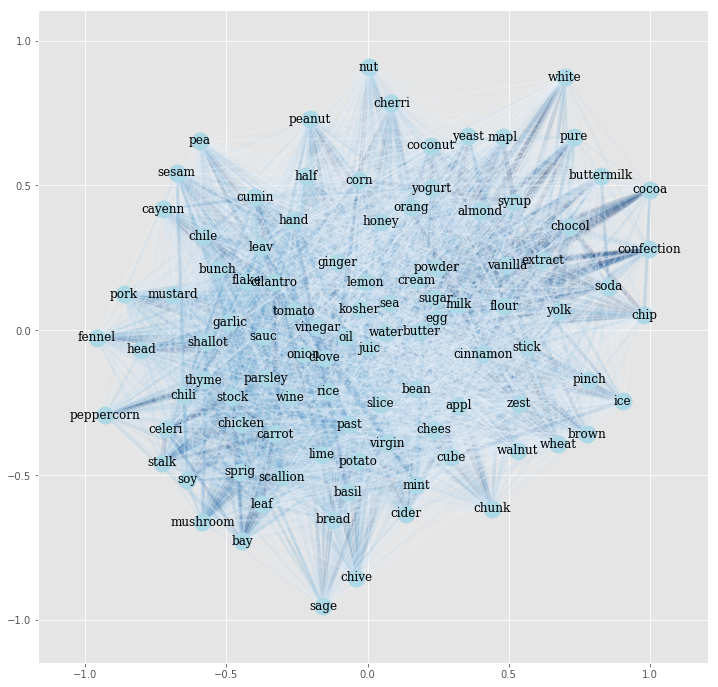

In [565]:
make_graph(full_features, 100)

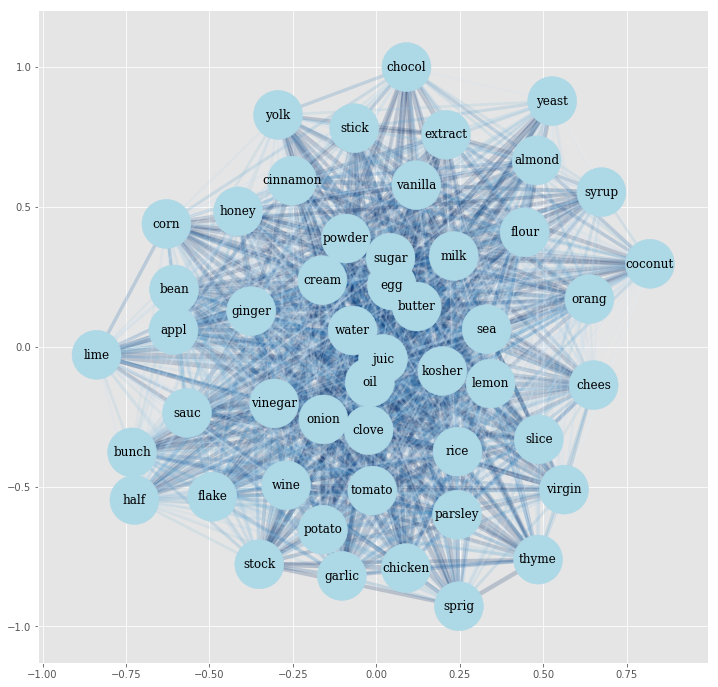

In [558]:
fig, ax = plt.subplots(figsize=(12,12))
node_and_degree=G.degree()
weights = np.array([G.get_edge_data(u,v)['weight'] for u,v in G.edges()])
# Draw graph
pos = nx.spring_layout(G, k=6/np.sqrt(G.order()))
_ = nx.draw_networkx_edges(G, pos=pos, ax=ax, alpha=0.2, width=weights**(1/3), 
                           edge_color=plt.cm.Blues(weights*5))
_ = nx.draw_networkx_nodes(G, node_size=[v**2 for v in dict(node_and_degree).values()],
                           pos=pos, ax=ax, node_color='lightblue')
_ = nx.draw_networkx_labels(G, pos=pos, font_family="serif", font_weight="ultralight")

In [1044]:
### Future work: Create a function to make graphs of a given list of ingredients